## 0. Import Modules and Datas

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

# ML / CV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

import matplotlib.pyplot as plt

# ==========================
# 0. 데이터 로드 + 기본 설정
# ==========================

DATA_PATH = Path("../data")
target_col = "market_forward_excess_returns"
leak_cols = ["forward_returns", "risk_free_rate"]  # 정답 공식에 직접 들어가는 애들

train_df_raw = pd.read_csv(DATA_PATH / "train.csv").sort_values("date_id").reset_index(drop=True)
print("Original shape:", train_df_raw.shape)

# 누수 컬럼 제거 (target은 유지)
train_df = train_df_raw.drop(columns=leak_cols)
print("After dropping leaks:", train_df.shape)

Original shape: (9021, 98)
After dropping leaks: (9021, 96)


## 1. Feature Engineering

In [2]:
def generate_FE_interaction_regime(df, target_col="market_forward_excess_returns"):
    """
    - target_col의 현재값(y_t)을 직접 쓰지 않고,
      항상 과거값 y_{t-1} 기준으로 rolling / vol / shock 계산.
    - macro(E*)도 마찬가지로 shift(1) 후 rolling.
    """
    df = df.copy()

    # ---- 타깃과 lag1 ----
    y = df[target_col]
    y_lag1 = y.shift(1)  # 항상 t-1까지의 정보만 사용

    # 1) Lag Features (target lag들)
    lags = [1, 2, 5, 10, 21, 63]
    for l in lags:
        df[f"{target_col}_lag{l}"] = y.shift(l)

    # 2) Rolling Stats (모두 y_lag1 기준)
    windows = [5, 10, 21, 63]
    for w in windows:
        roll_mean = y_lag1.rolling(w).mean()
        roll_std  = y_lag1.rolling(w).std()
        df[f"roll_mean_{w}"] = roll_mean
        df[f"roll_std_{w}"]  = roll_std
        df[f"roll_min_{w}"]  = y_lag1.rolling(w).min()
        df[f"roll_max_{w}"]  = y_lag1.rolling(w).max()
        df[f"zscore_{w}"]    = (y_lag1 - roll_mean) / (roll_std + 1e-9)

    # 3) Volatility Regime (y_lag1 기준)
    df["vol21"] = y_lag1.rolling(21).std()
    df["vol63"] = y_lag1.rolling(63).std()
    df["high_vol"] = (df["vol21"] > df["vol63"]).astype(int)

    # vol21의 과거 분포 기준 상위 10% (rolling quantile 근사)
    df["vol21_q90"] = df["vol21"].rolling(252, min_periods=50).quantile(0.9)
    df["crisis"] = (df["vol21"] > df["vol21_q90"]).astype(int)
    df.drop(columns=["vol21_q90"], inplace=True)

    df["vol_slope"] = df["vol21"] / (df["vol63"] + 1e-9)

    # 4) Macro Shock Regime (E* 계열, 모두 shift(1) 후 rolling)
    macro_cols = [c for c in df.columns if c.startswith("E")]
    for col in macro_cols:
        m_lag1 = df[col].shift(1)
        roll_mean_E = m_lag1.rolling(63).mean()
        roll_std_E  = m_lag1.rolling(63).std()
        df[f"{col}_z"] = (m_lag1 - roll_mean_E) / (roll_std_E + 1e-9)
        df[f"{col}_shock"] = (df[f"{col}_z"].abs() > 2).astype(int)

    shock_cols = [c for c in df.columns if c.endswith("_shock")]
    if len(shock_cols) > 0:
        df["macro_shock_sum"] = df[shock_cols].sum(axis=1)
        df["macro_crisis"] = (df["macro_shock_sum"] >= 3).astype(int)
    else:
        df["macro_shock_sum"] = 0
        df["macro_crisis"] = 0

    # 5) Momentum / Volatility Interaction
    momentum_cols = [c for c in df.columns if c.startswith("M")]
    vol_cols = [c for c in df.columns if c.startswith("V")]
    for m in momentum_cols[:5]:
        for v in vol_cols[:5]:
            df[f"{m}_x_{v}"] = df[m] * df[v]

    # 6) Macro Spread Interaction
    macro_pairs = [("E2", "E11"), ("E7", "E12"), ("E3", "E5")]
    for a, b in macro_pairs:
        if a in df.columns and b in df.columns:
            df[f"{a}_minus_{b}"] = df[a] - df[b]

    # 7) Return Shock (과거 분포 기준)
    y_std_hist = y_lag1.rolling(252, min_periods=50).std()
    df["return_shock"] = (y_lag1.abs() > 2 * (y_std_hist + 1e-9)).astype(int)

    # 8) Drop NaN
    df = df.dropna().reset_index(drop=True)
    return df


print("=== Step 1: Feature Engineering ===")
fe_df = generate_FE_interaction_regime(train_df, target_col)
print("FE_df shape:", fe_df.shape)


=== Step 1: Feature Engineering ===
FE_df shape: (1989, 198)


/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_93120/551917867.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{a}_minus_{b}"] = df[a] - df[b]
/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_93120/551917867.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{a}_minus_{b}"] = df[a] - df[b]
/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_93120/551917867.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

In [3]:
fe_df

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,M12_x_V13,M13_x_V1,M13_x_V10,M13_x_V11,M13_x_V12,M13_x_V13,E2_minus_E11,E7_minus_E12,E3_minus_E5,return_shock
0,7032,0,0,0,1,0,-1,0,0,0,...,0.503427,-0.983888,1.156909,-0.983235,-0.844264,0.880301,2.044429,1.179841,0.059040,0
1,7033,0,0,0,1,0,0,0,1,0,...,0.506244,-0.984084,1.229549,-0.982781,-0.805515,0.867335,2.168547,0.762491,0.221941,1
2,7034,0,0,0,1,1,0,0,1,0,...,0.442819,-0.988254,1.085659,-0.985638,-0.747567,0.754422,2.160085,0.762970,0.212634,0
3,7035,0,0,0,1,1,0,0,1,0,...,0.405344,-0.984058,1.091354,-0.978193,-0.737066,0.666411,2.262818,0.484171,0.348956,0
4,7036,0,0,0,1,1,0,0,0,1,...,0.522120,-0.985853,1.053199,-0.969531,-0.645048,0.841945,2.231446,1.146389,0.310217,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,9016,0,0,0,1,0,0,0,0,0,...,-0.020692,-0.402463,0.403718,-0.142748,-0.418623,0.292196,1.411814,0.106915,1.526627,0
1985,9017,0,0,0,1,0,0,0,0,0,...,-0.034717,-0.253747,0.452228,-0.125293,-0.407498,0.332001,1.408136,0.107114,1.521502,0
1986,9018,0,0,0,1,0,-1,0,0,0,...,-0.018726,-0.264900,0.391961,-0.121153,-0.320217,0.221852,1.352078,0.107314,1.459942,0
1987,9019,0,0,0,1,0,-1,0,0,0,...,-0.047653,-0.252352,0.485814,-0.146752,-0.346304,0.415682,1.404763,0.111787,1.515662,0


In [12]:
fe_df.columns

Index(['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9',
       ...
       'M12_x_V13', 'M13_x_V1', 'M13_x_V10', 'M13_x_V11', 'M13_x_V12',
       'M13_x_V13', 'E2_minus_E11', 'E7_minus_E12', 'E3_minus_E5',
       'return_shock'],
      dtype='object', length=198)

## 2. TS-CV: OOF 예측 + 성능

In [4]:
def ts_cv_oof_predictions(
    fe_df,
    target_col="market_forward_excess_returns",
    pca_components=15,
    n_splits=5
):
    df = fe_df.copy()
    y = df[target_col].values
    feature_cols = [c for c in df.columns if c != target_col]
    X_full = df[feature_cols].values
    n = len(df)

    # OOF 컨테이너
    oof_preds = {
        "ElasticNet": np.full(n, np.nan),
        "LightGBM": np.full(n, np.nan),
    }
    if HAS_XGB:
        oof_preds["XGBoost"] = np.full(n, np.nan)

    metrics = {
        "ElasticNet": {"rmse": [], "corr": []},
        "LightGBM": {"rmse": [], "corr": []},
    }
    if HAS_XGB:
        metrics["XGBoost"] = {"rmse": [], "corr": []}

    tscv = TimeSeriesSplit(n_splits=n_splits)
    indices = np.arange(n)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(indices), start=1):
        print(f"\n=== Fold {fold}/{n_splits} ===")
        X_tr, X_val = X_full[train_idx], X_full[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        # ----- ElasticNet (Scaler+PCA per fold) -----
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        pca = PCA(n_components=pca_components, random_state=42)
        X_tr_pca = pca.fit_transform(X_tr_scaled)
        X_val_pca = pca.transform(X_val_scaled)

        enet = ElasticNet(alpha=1e-3, l1_ratio=0.1, max_iter=5000, random_state=42)
        enet.fit(X_tr_pca, y_tr)
        pred_en = enet.predict(X_val_pca)

        rmse_en = np.sqrt(mean_squared_error(y_val, pred_en))
        corr_en = np.corrcoef(y_val, pred_en)[0, 1]
        metrics["ElasticNet"]["rmse"].append(rmse_en)
        metrics["ElasticNet"]["corr"].append(corr_en)
        oof_preds["ElasticNet"][val_idx] = pred_en

        print(f"[ElasticNet] RMSE={rmse_en:.6f}, Corr={corr_en:.4f}")

        # ----- LightGBM -----
        lgb_train = lgb.Dataset(X_tr, label=y_tr)
        lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

        lgb_params = {
            "objective": "regression",
            "metric": "rmse",
            "learning_rate": 0.03,
            "num_leaves": 63,
            "feature_fraction": 0.8,
            "bagging_fraction": 0.8,
            "bagging_freq": 5,
            "seed": 42,
        }

        lgb_model = lgb.train(
            lgb_params,
            lgb_train,
            num_boost_round=800,
            valid_sets=[lgb_valid],
        )
        pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

        rmse_lgb = np.sqrt(mean_squared_error(y_val, pred_lgb))
        corr_lgb = np.corrcoef(y_val, pred_lgb)[0, 1]
        metrics["LightGBM"]["rmse"].append(rmse_lgb)
        metrics["LightGBM"]["corr"].append(corr_lgb)
        oof_preds["LightGBM"][val_idx] = pred_lgb

        print(f"[LightGBM]  RMSE={rmse_lgb:.6f}, Corr={corr_lgb:.4f}")

        # ----- XGBoost -----
        if HAS_XGB:
            dtrain = xgb.DMatrix(X_tr, label=y_tr)
            dval = xgb.DMatrix(X_val, label=y_val)

            xgb_params = {
                "objective": "reg:squarederror",
                "eval_metric": "rmse",
                "eta": 0.03,
                "max_depth": 6,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "seed": 42,
            }
            evallist = [(dval, "valid")]
            xgb_model = xgb.train(
                xgb_params,
                dtrain,
                num_boost_round=800,
                evals=evallist,
            )
            pred_xgb = xgb_model.predict(dval)

            rmse_xgb = np.sqrt(mean_squared_error(y_val, pred_xgb))
            corr_xgb = np.corrcoef(y_val, pred_xgb)[0, 1]
            metrics["XGBoost"]["rmse"].append(rmse_xgb)
            metrics["XGBoost"]["corr"].append(corr_xgb)
            oof_preds["XGBoost"][val_idx] = pred_xgb

            print(f"[XGBoost]  RMSE={rmse_xgb:.6f}, Corr={corr_xgb:.4f}")

    print("\n=== Summary (mean over folds, OOF 기준) ===")
    for model, vals in metrics.items():
        rmse_mean = np.mean(vals["rmse"])
        rmse_std = np.std(vals["rmse"])
        corr_mean = np.mean(vals["corr"])
        corr_std = np.std(vals["corr"])
        print(f"\n[{model}]")
        print(f"RMSE: {rmse_mean:.6f} ± {rmse_std:.6f}")
        print(f"Corr: {corr_mean:.4f} ± {corr_std:.4f}")

    return y, oof_preds, metrics, feature_cols


print("\n=== Step 2: TS-CV + OOF ===")
y, oof_preds, metrics, feature_cols = ts_cv_oof_predictions(
    fe_df,
    target_col=target_col,
    pca_components=15,
    n_splits=5
)


=== Step 2: TS-CV + OOF ===

=== Fold 1/5 ===
[ElasticNet] RMSE=0.014723, Corr=0.0903
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17203
[LightGBM] [Info] Number of data points in the train set: 334, number of used features: 192
[LightGBM] [Info] Start training from score -0.000048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

## 3. Baseline (mean) 모델

In [5]:
from sklearn.model_selection import TimeSeriesSplit

def ts_cv_baseline_mean(y, n_splits=5):
    y = np.asarray(y)
    n = len(y)
    tscv = TimeSeriesSplit(n_splits=n_splits)

    oof_baseline = np.full(n, np.nan)
    rmse_list, corr_list = [], []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(np.arange(n)), start=1):
        y_tr, y_val = y[train_idx], y[val_idx]
        mean_tr = y_tr.mean()
        pred_val = np.full_like(y_val, fill_value=mean_tr, dtype=float)

        rmse = np.sqrt(mean_squared_error(y_val, pred_val))
        corr = np.corrcoef(y_val, pred_val)[0, 1]

        rmse_list.append(rmse)
        corr_list.append(corr)
        oof_baseline[val_idx] = pred_val

        print(f"[Baseline-Mean] Fold {fold}: RMSE={rmse:.6f}, Corr={corr:.4f}")

    metrics_baseline = {
        "rmse": rmse_list,
        "corr": corr_list,
    }

    print("\n=== Summary (Baseline – mean over folds) ===")
    print(f"RMSE: {np.mean(rmse_list):.6f} ± {np.std(rmse_list):.6f}")
    print(f"Corr: {np.mean(corr_list):.4f} ± {np.std(corr_list):.4f}")

    return oof_baseline, metrics_baseline


print("\n=== Step 3: Baseline ===")
oof_baseline, metrics_baseline = ts_cv_baseline_mean(y, n_splits=5)



=== Step 3: Baseline ===
[Baseline-Mean] Fold 1: RMSE=0.013792, Corr=-0.0000
[Baseline-Mean] Fold 2: RMSE=0.008852, Corr=0.0000
[Baseline-Mean] Fold 3: RMSE=0.014053, Corr=0.0000
[Baseline-Mean] Fold 4: RMSE=0.007377, Corr=nan
[Baseline-Mean] Fold 5: RMSE=0.009956, Corr=nan

=== Summary (Baseline – mean over folds) ===
RMSE: 0.010806 ± 0.002674
Corr: nan ± nan


/Users/youjunglee/머러플_P4/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/youjunglee/머러플_P4/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/youjunglee/머러플_P4/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/youjunglee/머러플_P4/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## 4. 모델 성능 요약 테이블

In [6]:
def summarize_all_models(metrics_baseline, metrics_ml):
    rows = []

    rows.append({
        "Model": "Baseline-Mean",
        "RMSE_mean": np.mean(metrics_baseline["rmse"]),
        "RMSE_std":  np.std(metrics_baseline["rmse"]),
        "Corr_mean": np.mean(metrics_baseline["corr"]),
        "Corr_std":  np.std(metrics_baseline["corr"]),
    })

    for name, vals in metrics_ml.items():
        rows.append({
            "Model": name,
            "RMSE_mean": np.mean(vals["rmse"]),
            "RMSE_std":  np.std(vals["rmse"]),
            "Corr_mean": np.mean(vals["corr"]),
            "Corr_std":  np.std(vals["corr"]),
        })

    summary_df = pd.DataFrame(rows)
    summary_df = summary_df.sort_values("RMSE_mean").reset_index(drop=True)
    return summary_df

summary_df = summarize_all_models(metrics_baseline, metrics)
print("\n=== Model Comparison Summary ===")
print(summary_df)



=== Model Comparison Summary ===
           Model  RMSE_mean  RMSE_std  Corr_mean  Corr_std
0  Baseline-Mean   0.010806  0.002674        NaN       NaN
1     ElasticNet   0.011171  0.002785   0.034909  0.056490
2       LightGBM   0.012239  0.002517   0.029710  0.047885
3        XGBoost   0.012440  0.002475   0.039087  0.050458


In [7]:
def compute_metric(y_true, y_pred, metric="rmse"):
    if metric == "rmse":
        return np.sqrt(mean_squared_error(y_true, y_pred))
    elif metric == "neg_corr":
        corr = np.corrcoef(y_true, y_pred)[0, 1]
        return -corr
    else:
        raise ValueError

def optimize_blend_weights(y, oof_preds, metric="rmse", grid_step=0.05):
    model_names = list(oof_preds.keys())
    n_models = len(model_names)

    # 모든 모델이 예측을 가진 공통 구간
    valid_mask = np.ones_like(y, dtype=bool)
    for m in model_names:
        valid_mask &= ~np.isnan(oof_preds[m])
    y_valid = y[valid_mask]
    preds_valid = {m: oof_preds[m][valid_mask] for m in model_names}

    best_score = None
    best_weights = None
    grid = np.arange(0.0, 1.0 + 1e-9, grid_step)

    if n_models == 2:
        m1, m2 = model_names
        for w1 in grid:
            w2 = 1.0 - w1
            blend = w1 * preds_valid[m1] + w2 * preds_valid[m2]
            score = compute_metric(y_valid, blend, metric=metric)
            if (best_score is None) or (score < best_score):
                best_score = score
                best_weights = {m1: w1, m2: w2}

    elif n_models == 3:
        m1, m2, m3 = model_names
        for w1 in grid:
            for w2 in grid:
                if w1 + w2 > 1.0:
                    continue
                w3 = 1.0 - w1 - w2
                blend = (
                    w1 * preds_valid[m1]
                    + w2 * preds_valid[m2]
                    + w3 * preds_valid[m3]
                )
                score = compute_metric(y_valid, blend, metric=metric)
                if (best_score is None) or (score < best_score):
                    best_score = score
                    best_weights = {m1: w1, m2: w2, m3: w3}
    else:
        raise ValueError("2~3개 모델만 지원")

    print(f"\n=== Best Blend Weights (metric: {metric}) ===")
    for m in model_names:
        print(f"{m}: {best_weights.get(m, 0.0):.3f}")

    if metric == "rmse":
        print(f"Best OOF RMSE: {best_score:.6f}")
    else:
        print(f"Best OOF score (neg_corr): {best_score:.6f}")

    return best_weights, best_score


blend_rmse, best_rmse = optimize_blend_weights(y, oof_preds, metric="rmse", grid_step=0.05)
blend_corr, best_neg_corr = optimize_blend_weights(y, oof_preds, metric="neg_corr", grid_step=0.05)
print("\n[Blend] RMSE-opt:", blend_rmse, "RMSE:", best_rmse)
print("[Blend] Corr-opt:", blend_corr, "Corr:", -best_neg_corr)



=== Best Blend Weights (metric: rmse) ===
ElasticNet: 0.950
LightGBM: 0.050
XGBoost: -0.000
Best OOF RMSE: 0.011510

=== Best Blend Weights (metric: neg_corr) ===
ElasticNet: 1.000
LightGBM: 0.000
XGBoost: 0.000
Best OOF score (neg_corr): -0.035093

[Blend] RMSE-opt: {'ElasticNet': np.float64(0.9500000000000001), 'LightGBM': np.float64(0.05), 'XGBoost': np.float64(-6.938893903907228e-17)} RMSE: 0.011510100635582582
[Blend] Corr-opt: {'ElasticNet': np.float64(1.0), 'LightGBM': np.float64(0.0), 'XGBoost': np.float64(0.0)} Corr: 0.03509298816502523


Blend 예측 설계 및 성능 확인

In [ ]:
# 1) 공통 valid 구간 (OOF 예측이 다 있는 구간만 사용)
model_names = ["ElasticNet", "LightGBM", "XGBoost"]
valid_mask = np.ones_like(y, dtype=bool)
for m in model_names:
    valid_mask &= ~np.isnan(oof_preds[m])

y_valid = y[valid_mask]

# 2) 우리가 이미 구한 RMSE-opt blend weight 그대로 사용
#    (ElasticNet 0.95, LGBM 0.05, XGB는 ~0이라 0으로 처리)
w_en = 0.95
w_lgb = 0.05
w_xgb = 0.0   # float rounding 방지

pred_en  = oof_preds["ElasticNet"][valid_mask]
pred_lgb = oof_preds["LightGBM"][valid_mask]
pred_xgb = oof_preds["XGBoost"][valid_mask]

pred_blend = (
    w_en  * pred_en +
    w_lgb * pred_lgb +
    w_xgb * pred_xgb
)

# 3) Blend 예측의 OOF 성능 (참고용)
rmse_blend = np.sqrt(mean_squared_error(y_valid, pred_blend))
corr_blend = np.corrcoef(y_valid, pred_blend)[0, 1]

print("=== Blend (0.95 EN + 0.05 LGB) – OOF Performance ===")
print(f"RMSE : {rmse_blend:.6f}")
print(f"Corr : {corr_blend:.4f}")
# 베이스라인이 RMSE: 0.010806 ± 0.002674


=== Blend (0.95 EN + 0.05 LGB) – OOF Performance ===
RMSE : 0.011510
Corr : 0.0335


In [10]:
def prediction_to_weight_blend(y_pred, k=50.0):
    """
    y_pred: blended OOF prediction (excess return)
    k: aggressiveness (클수록 레버리지 크게, 기본 50 정도로 시작)

    1) z-score 로 표준화
    2) w = 1 + k * z
    3) clip to [0, 2]
    """
    y_pred = np.asarray(y_pred)
    z = (y_pred - y_pred.mean()) / (y_pred.std() + 1e-9)
    w = 1.0 + k * z
    w = np.clip(w, 0.0, 2.0)
    return w

def evaluate_strategy_blend(y_true, y_pred, k=50.0, annualization=252, max_vol_ratio=1.2):
    """
    y_true: realized excess return (y_valid)
    y_pred: blended prediction (pred_blend)
    k: aggressiveness
    max_vol_ratio: 전략 변동성 / 벤치마크 변동성 ≤ 1.2 제약
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # 1) Benchmark (항상 w=1)
    ret_bench = y_true

    # 2) 초기 weight
    w_raw = prediction_to_weight_blend(y_pred, k=k)
    ret_strat = w_raw * y_true

    # 3) 변동성 계산
    vol_bench = ret_bench.std() * np.sqrt(annualization)
    vol_strat = ret_strat.std() * np.sqrt(annualization)

    # 4) vol 제약 120% 넘으면 weight scale
    max_vol = max_vol_ratio * vol_bench
    if vol_strat > max_vol:
        scale = max_vol / (vol_strat + 1e-9)
        w = np.clip(w_raw * scale, 0.0, 2.0)
        ret_strat = w * y_true
        vol_strat = ret_strat.std() * np.sqrt(annualization)
    else:
        w = w_raw

    # 5) Sharpe
    sharpe_bench = ret_bench.mean() / (ret_bench.std() + 1e-9) * np.sqrt(annualization)
    sharpe_strat = ret_strat.mean() / (ret_strat.std() + 1e-9) * np.sqrt(annualization)

    cum_bench = (1 + ret_bench).cumprod() - 1
    cum_strat = (1 + ret_strat).cumprod() - 1

    return {
        "mean_return_bench": ret_bench.mean(),
        "mean_return_strat": ret_strat.mean(),
        "vol_bench": vol_bench,
        "vol_strat": vol_strat,
        "vol_ratio": vol_strat / (vol_bench + 1e-9),
        "sharpe_bench": sharpe_bench,
        "sharpe_strat": sharpe_strat,
        "final_cumret_bench": float(cum_bench[-1]),
        "final_cumret_strat": float(cum_strat[-1]),
        "weights": w,
        "ret_bench": ret_bench,
        "ret_strat": ret_strat,
    }

def search_best_k_for_blend(y_true, y_pred, k_grid, max_vol_ratio=1.2):
    best_k = None
    best_sharpe = -1e9
    best_res = None

    for k in k_grid:
        res = evaluate_strategy_blend(y_true, y_pred, k=k, max_vol_ratio=max_vol_ratio)
        if res["vol_ratio"] <= max_vol_ratio:
            if res["sharpe_strat"] > best_sharpe:
                best_sharpe = res["sharpe_strat"]
                best_k = k
                best_res = res
    return best_k, best_res


=== Blend Strategy (ElasticNet 0.95 + LGBM 0.05) ===
Best k: 0.5
mean_return_bench: 0.00026529112000813306
mean_return_strat: 0.00033078310976902305
vol_bench: 0.17661231447784878
vol_strat: 0.21193477643068365
vol_ratio: 1.1999999878675793
sharpe_bench: 0.3785316807080875
sharpe_strat: 0.39331599476954743
final_cumret_bench: 0.3997951143097216
final_cumret_strat: 0.4913627553218616


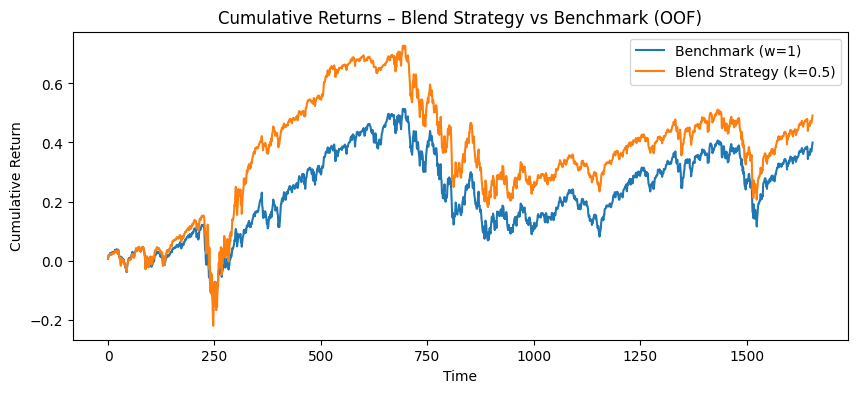

In [11]:
# k 후보: 너무 거칠지 않게 0~50 사이를 0.5 간격으로
k_candidates = np.arange(0.0, 50.5, 0.5)

best_k_blend, best_res_blend = search_best_k_for_blend(
    y_valid,
    pred_blend,
    k_grid=k_candidates,
    max_vol_ratio=1.2    # 120% 제약
)

print("=== Blend Strategy (ElasticNet 0.95 + LGBM 0.05) ===")
print(f"Best k: {best_k_blend}")

for key, val in best_res_blend.items():
    if key not in ["weights", "ret_bench", "ret_strat"]:
        print(f"{key}: {val}")

# 누적수익률 그래프
plt.figure(figsize=(10,4))
cum_bench = (1 + best_res_blend["ret_bench"]).cumprod() - 1
cum_strat = (1 + best_res_blend["ret_strat"]).cumprod() - 1

plt.plot(cum_bench, label="Benchmark (w=1)")
plt.plot(cum_strat, label=f"Blend Strategy (k={best_k_blend})")
plt.legend()
plt.title("Cumulative Returns – Blend Strategy vs Benchmark (OOF)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()

본 프로젝트의 결과는 효율적 시장 가설(EMH)을 부정하지 않는다.

대신, 시장 수익률 자체는 랜덤에 가깝지만

factor-structure와 regime-shift 기반의 매우 약한 예측가능성은 존재하며,

이를 적절히 vol-targeting 전략과 결합하면

벤치마크 대비 소폭의 위험조정 성과 개선이 가능함을 확인하였다.